<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/2022project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import PIL
import time
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle as p
import plotly
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import plotly.graph_objs as go
from tensorflow import keras
from tensorflow.keras.models import Sequential

## เตรียมชุดของข้อมูล

In [ ]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่า Mounted at /content/drive 
drive.mount('/content/drive')
path = '/content/drive/My Drive/dataeye'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/dataeye')

In [ ]:
batch_size = 20   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 224  # ความสูงของรูปภาพแต่ละรูป
img_width = 224   # ความกว้างของรูปภาพแต่ละรูป

## Train

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
validation_split=0.1, # s แบ่งข้อมูล เพื่อ training 90% และ validation 10%
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)
val = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.1,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 16556 files belonging to 3 classes.
Using 14901 files for training.
Found 16556 files belonging to 3 classes.
Using 1655 files for validation.


In [ ]:
class_names = train.class_names
print(class_names)

['Crop CSC', 'Crop PCV', 'Crop VKH']


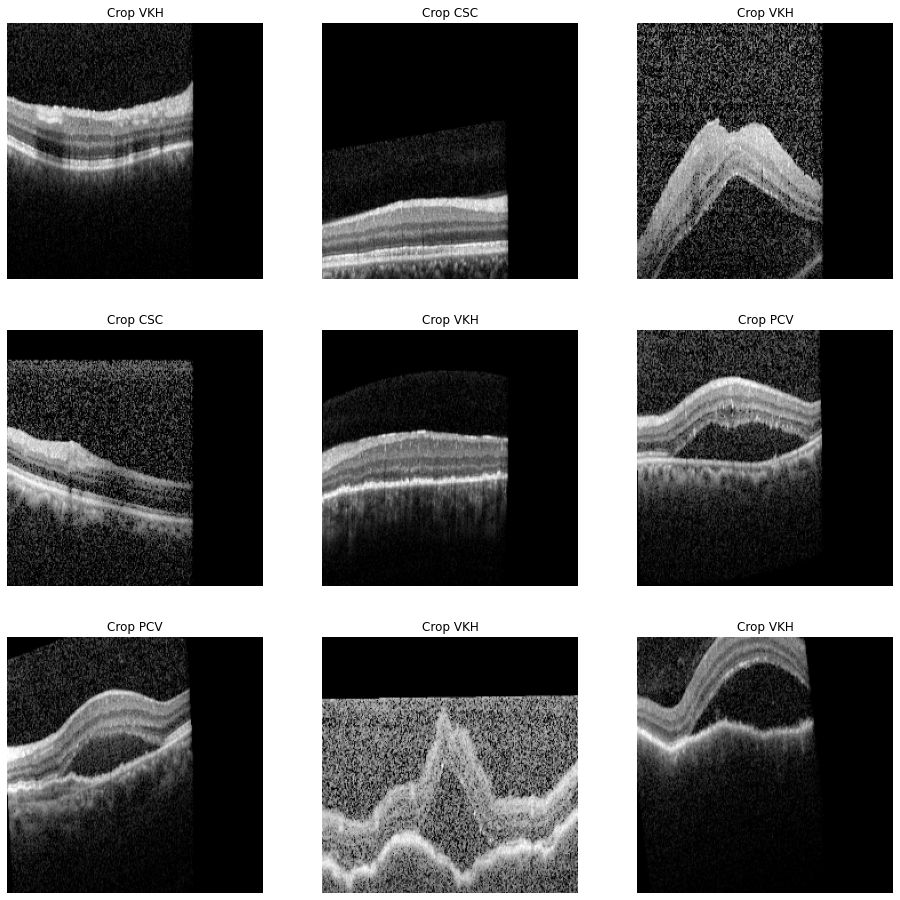

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16)) #ขนาด
for images, labels in train.take(1):
  for i in range(9): #มี 15 รูป
    ax = plt.subplot(3, 3, i + 1) #แถวละ 3
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 224, 224, 3)
(20,)


## Normalization

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9974791


## Model

In [ ]:
num_classes = 3
epochs=10   # จำนวนครั้งที่เราจะ Train

In [ ]:
model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [ ]:
his = model.fit(
train,
validation_data=val,
epochs=epochs
)

Epoch 1/10
746/746 [==============================] - 1872s 2s/step - loss: 0.7123 - accuracy: 0.6734 - val_loss: 0.4288 - val_accuracy: 0.8314
Epoch 2/10
746/746 [==============================] - 139s 185ms/step - loss: 0.2269 - accuracy: 0.9148 - val_loss: 0.4230 - val_accuracy: 0.8574
Epoch 3/10
746/746 [==============================] - 137s 182ms/step - loss: 0.0779 - accuracy: 0.9730 - val_loss: 0.2877 - val_accuracy: 0.9221
Epoch 4/10
746/746 [==============================] - 138s 184ms/step - loss: 0.0363 - accuracy: 0.9878 - val_loss: 0.2530 - val_accuracy: 0.9408
Epoch 5/10
746/746 [==============================] - 137s 183ms/step - loss: 0.0331 - accuracy: 0.9895 - val_loss: 0.2568 - val_accuracy: 0.9311
Epoch 6/10
746/746 [==============================] - 139s 184ms/step - loss: 0.0152 - accuracy: 0.9945 - val_loss: 0.2478 - val_accuracy: 0.9402
Epoch 7/10
746/746 [==============================] - 136s 181ms/step - loss: 0.0221 - accuracy: 0.9933 - val_loss: 0.2551 - v

## Save Model

In [ ]:
with open('history_model', 'wb') as file:
   p.dump(his.history, file)

filepath='model1.h5'
model.save(filepath)
filepath_model = 'model1.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")

Saved model to disk


## Load Model

In [ ]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['loss'],
mode="lines", line=dict(
width=2,
color='blue'),
name="loss"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testMNIST")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

## Prediction

1/1 [==============================] - 0s 29ms/step
Crop CSC tf.Tensor(1.0, shape=(), dtype=float32) Crop PCV tf.Tensor(2.3602985e-14, shape=(), dtype=float32) Crop VKH tf.Tensor(3.7449757e-12, shape=(), dtype=float32)


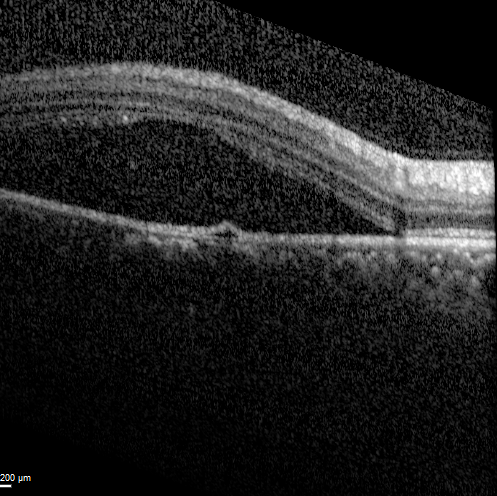

AI Crop CSC มีความมั่นใจ 100.00%.


In [ ]:
import requests
from IPython.display import Image
from io import BytesIO
test_path = ('/content/drive/My Drive/testeye/test c.png')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("Crop CSC",score[0],"Crop PCV",score[1],"Crop VKH",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "Crop CSC"
elif score[1]==np.max(score) :
   fruit = "Crop PCV"
elif score[2]==np.max(score) :
   fruit = "Crop VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 16ms/step
Crop CSC tf.Tensor(0.0017466694, shape=(), dtype=float32) Crop PCV tf.Tensor(0.9982522, shape=(), dtype=float32) Crop VKH tf.Tensor(1.0637563e-06, shape=(), dtype=float32)


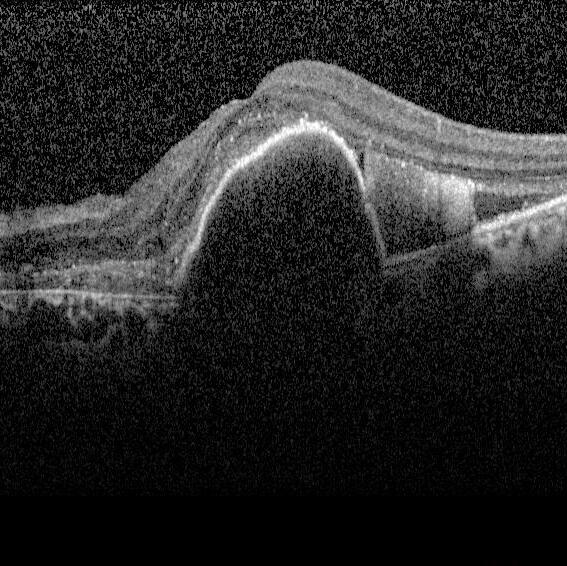

AI Crop PCV มีความมั่นใจ 99.83%.


In [ ]:
test_path = ('/content/drive/My Drive/testeye/test p.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("Crop CSC",score[0],"Crop PCV",score[1],"Crop VKH",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "Crop CSC"
elif score[1]==np.max(score) :
   fruit = "Crop PCV"
elif score[2]==np.max(score) :
   fruit = "Crop VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 16ms/step
Crop CSC tf.Tensor(0.24118468, shape=(), dtype=float32) Crop PCV tf.Tensor(0.000119096876, shape=(), dtype=float32) Crop VKH tf.Tensor(0.7586962, shape=(), dtype=float32)


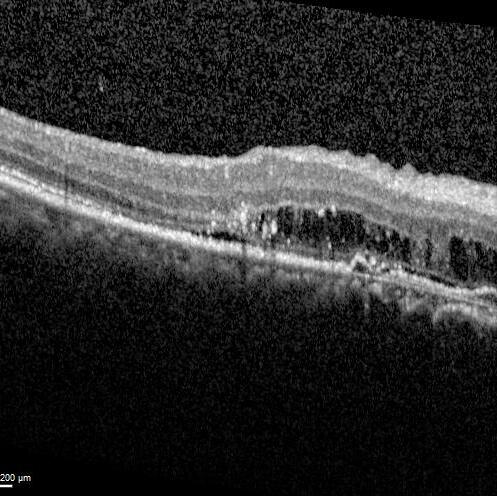

AI Crop VKH มีความมั่นใจ 75.87%.


In [ ]:
test_path = ('/content/drive/My Drive/testeye/test v.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("Crop CSC",score[0],"Crop PCV",score[1],"Crop VKH",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "Crop CSC"
elif score[1]==np.max(score) :
   fruit = "Crop PCV"
elif score[2]==np.max(score) :
   fruit = "Crop VKH"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)